# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [211]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import ujson
import tqdm

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score

%matplotlib inline

In [4]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [5]:
PATH_TO_DATA = "../data/"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [6]:
df_train_features.shape

(31698, 245)

In [7]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [8]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [9]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [11]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 49.1 s, sys: 175 ms, total: 49.3 s
Wall time: 6.84 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [12]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [13]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [14]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [15]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                            index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [16]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(''.join(['../data/', submission_filename]))
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-26_14-49-00.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [17]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [18]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 12.2 s, sys: 1.05 s, total: 13.2 s
Wall time: 47.7 s


In [19]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [20]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [21]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строк
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [22]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [23]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

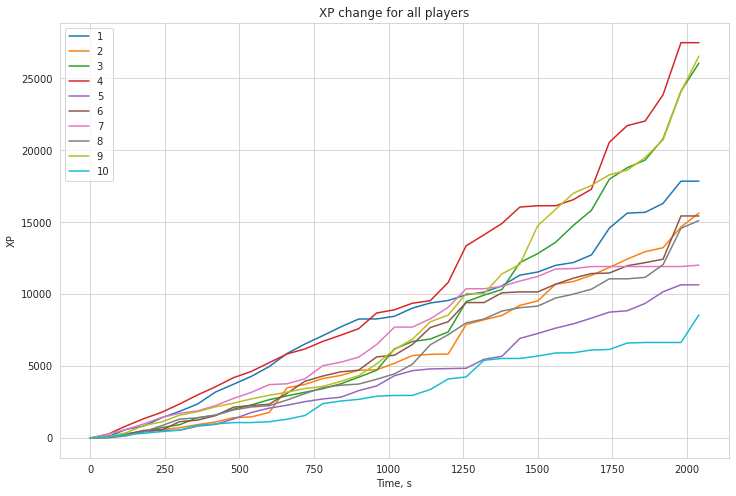

In [24]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [25]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [26]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [27]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [28]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [29]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 114 ms, sys: 133 ms, total: 247 ms
Wall time: 1min 14s


In [30]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

# Прочитаем побольше всего

In [71]:
def add_new_features(df_features, matches_file, total_matches=31698):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file, total_matches=total_matches):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills, dire_tower_kills = 0, 0
        
        # и другие данные
        first_blood = 0
        aegis_stolen_radiant, aegis_stolen_dire = 0, 0
        aegis_denied_radiant, aegis_denied_dire = 0, 0
        radiant_roshan_kills, dire_roshan_kills = 0, 0
        barracks_kill = 0

        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1
                    
            if objective["type"] == "CHAT_MESSAGE_ROSHAN_KILL":
                if objective["team"] == 2:
                    radiant_roshan_kills += 1
                if objective["team"] == 3:
                    dire_roshan_kills += 1
                    
            if objective["type"] == "CHAT_MESSAGE_BARRACKS_KILL":
                barracks_kill += 1
                    
            if objective["type"] == "CHAT_MESSAGE_FIRSTBLOOD":
                if objective["player_slot"] < 6:
                    first_blood = 1
                    
            if objective["type"] == "CHAT_MESSAGE_AEGIS_STOLEN":
                if objective["player_slot"] < 6:
                    aegis_stolen_radiant += 1
                if objective["player_slot"] > 50:
                    aegis_stolen_dire += 1
            
            if objective["type"] == "CHAT_MESSAGE_DENIED_AEGIS":
                if objective["player_slot"] < 6:
                    aegis_denied_radiant += 1
                if objective["player_slot"] > 50:
                    aegis_denied_dire += 1
        
        if dire_tower_kills != 0:
            df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills / dire_tower_kills
        else:
            df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills
        
        df_features.loc[match_id_hash, "first_blood"] = first_blood
        df_features.loc[match_id_hash, "barracks_kill"] = barracks_kill        
        
        if aegis_stolen_dire != 0:
            df_features.loc[match_id_hash, "aegis_stolen_diff"] = aegis_stolen_radiant / aegis_stolen_dire
        else:
            df_features.loc[match_id_hash, "aegis_stolen_diff"] = aegis_stolen_radiant
            
        if aegis_denied_dire != 0:
            df_features.loc[match_id_hash, "aegis_denied_diff"] = aegis_denied_radiant / aegis_denied_dire
        else:
            df_features.loc[match_id_hash, "aegis_denied_diff"] = aegis_denied_radiant
        
        if dire_roshan_kills != 0:
            df_features.loc[match_id_hash, "diff_roshan_kills"] = radiant_roshan_kills / dire_roshan_kills
        else:
            df_features.loc[match_id_hash, "diff_roshan_kills"] = radiant_roshan_kills
            
        dire_ability_uses = 0
        rad_ability_uses = 0
                
        for player in match["players"]:
            if player['player_slot'] > 90:
                for i in player["ability_uses"].values():
                    dire_ability_uses += i
            else:
                for i in player["ability_uses"].values():
                    rad_ability_uses += i
        
        df_features.loc[match_id_hash, "rad_ability_uses"] = rad_ability_uses
        df_features.loc[match_id_hash, "dire_ability_uses"] = dire_ability_uses 
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [138]:
# Скопируем таблицу с признаками
train = df_train_features.copy()

# Добавим новые
add_new_features(train, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

# Some EDA

In [139]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31698 entries, b9c57c450ce74a2af79c9ce96fac144d to e2ca68ac1a6847f4a37f6c9c8ee8695b
Columns: 253 entries, game_time to dire_ability_uses
dtypes: float64(38), int64(215)
memory usage: 62.4+ MB


In [140]:
train.describe()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_obs_placed,d5_sen_placed,diff_tower_kills,first_blood,barracks_kill,aegis_stolen_diff,aegis_denied_diff,diff_roshan_kills,rad_ability_uses,dire_ability_uses
count,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,...,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000
mean,1146.519496,19.583538,4.771563,6.535239,7.358982,51.081614,3.151713,3.273361,4.661998,6.255600,...,1.255568,0.780933,1.101959,0.467253,0.569500,0.003470,0.000505,0.144838,330.375450,334.947094
std,766.936655,6.306635,3.260899,6.486933,13.295763,34.573173,3.727116,3.281208,5.207887,8.144267,...,2.582681,2.436478,1.665859,0.498934,1.422925,0.058807,0.022462,0.419616,430.150165,440.778588
min,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,521.000000,22.000000,0.000000,1.000000,0.000000,20.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,89.000000,89.000000
50%,1044.000000,22.000000,7.000000,4.000000,3.000000,44.000000,2.000000,2.000000,3.000000,3.000000,...,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,225.000000,226.000000
75%,1659.000000,22.000000,7.000000,10.000000,9.000000,81.000000,5.000000,5.000000,7.000000,9.000000,...,1.000000,0.000000,1.500000,1.000000,0.000000,0.000000,0.000000,0.000000,420.000000,422.000000
max,4933.000000,23.000000,7.000000,43.000000,291.000000,120.000000,32.000000,27.000000,40.000000,83.000000,...,26.000000,47.000000,11.000000,1.000000,12.000000,1.000000,1.000000,5.000000,7879.000000,7727.000000


In [141]:
train.isnull().sum().sum()

0

In [142]:
# make KDA for each player
for i in range(1, 6):
    train[f'd{i}_KDA'] = np.where(train[f'd{i}_deaths'] != 0, 
                                 (train[f'd{i}_kills'] + train[f'd{i}_assists']) / train[f'd{i}_deaths'],
                                  train[f'd{i}_kills'] + train[f'd{i}_assists'],)
        
    train[f'r{i}_KDA'] = np.where(train[f'r{i}_deaths'] != 0, 
                                 (train[f'r{i}_kills'] + train[f'r{i}_assists']) / train[f'r{i}_deaths'],
                                  train[f'r{i}_kills'] + train[f'r{i}_assists'],)
    
    train = train.drop([f'd{i}_kills', f'd{i}_assists', f'd{i}_deaths',
                        f'r{i}_kills', f'r{i}_assists', f'r{i}_deaths'],
                      axis=1)

In [143]:
# health for  each player
for i in range(1, 6):
    train[f'r{i}_pc_health'] = train[f'r{i}_health'] / train[f'r{i}_max_health']
    train[f'd{i}_pc_health'] = train[f'd{i}_health'] / train[f'd{i}_max_health']
    
    train = train.drop([f'r{i}_health', f'r{i}_max_health', f'd{i}_health', f'd{i}_max_health'], axis=1)

In [144]:
train.iloc[:,5:24]

,r1_hero_id,r1_denies,r1_gold,r1_lh,r1_xp,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,15,7,5257,52,3937,566.93805,8,76,78,0.000000,0,0,0,0,0.437500,0,0,0,0
6db558535151ea18ca70a6892197db41,101,0,176,0,0,506.93800,1,118,118,0.000000,0,0,0,0,0.000000,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,57,1,403,0,359,290.93777,2,92,148,0.000000,0,0,1,0,0.000000,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,119,5,3085,1,2828,816.93830,6,112,112,21.451569,0,0,18,0,0.300000,0,0,5,2
156c88bff4e9c4668b0f53df3d870f1b,12,9,3516,40,3964,530.93800,8,120,118,0.000000,0,0,2,0,0.833333,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,99,3,19850,251,25448,2179.93970,24,152,148,0.000000,0,0,11,0,0.580645,0,0,0,0
308faee28efee2e66b39f9f2ba6ea9cf,22,3,13914,151,19592,2197.93970,21,132,136,4.672524,1,1,5,0,0.629630,0,1,0,0
6066cc7417b43c749d551e123d00f0c8,1,0,4613,59,4478,410.93790,9,152,92,0.000019,0,0,2,0,0.285714,0,0,0,0


In [145]:
for i in range(1, 6):
    print(train[[f'r{i}_level', f'r{i}_xp']].corr())

          r1_level     r1_xp
r1_level  1.000000  0.973307
r1_xp     0.973307  1.000000
          r2_level     r2_xp
r2_level  1.000000  0.973125
r2_xp     0.973125  1.000000
          r3_level     r3_xp
r3_level  1.000000  0.973374
r3_xp     0.973374  1.000000
          r4_level     r4_xp
r4_level  1.000000  0.973228
r4_xp     0.973228  1.000000
          r5_level     r5_xp
r5_level  1.000000  0.973169
r5_xp     0.973169  1.000000


In [146]:
for i in range(1, 6):
    print(train[[f'd{i}_level', f'd{i}_xp']].corr())

          d1_level     d1_xp
d1_level  1.000000  0.973569
d1_xp     0.973569  1.000000
          d2_level     d2_xp
d2_level  1.000000  0.973276
d2_xp     0.973276  1.000000
          d3_level     d3_xp
d3_level  1.000000  0.973352
d3_xp     0.973352  1.000000
          d4_level     d4_xp
d4_level  1.000000  0.973324
d4_xp     0.973324  1.000000
          d5_level     d5_xp
d5_level  1.000000  0.973229
d5_xp     0.973229  1.000000


количество опыта с уровнем сильно коррелируют, оставим только уровень.

In [147]:
for i in range(1, 6):
    train = train.drop([f'd{i}_xp', f'r{i}_xp'], axis=1)

In [148]:
for i in range(1, 6):
    print(train[[f'd{i}_lh', f'd{i}_gold']].corr())

            d1_lh   d1_gold
d1_lh    1.000000  0.867097
d1_gold  0.867097  1.000000
           d2_lh  d2_gold
d2_lh    1.00000  0.86494
d2_gold  0.86494  1.00000
            d3_lh   d3_gold
d3_lh    1.000000  0.868328
d3_gold  0.868328  1.000000
            d4_lh   d4_gold
d4_lh    1.000000  0.867114
d4_gold  0.867114  1.000000
            d5_lh   d5_gold
d5_lh    1.000000  0.862931
d5_gold  0.862931  1.000000


In [149]:
# creeps and camps sum

train['r_crepps_sum'] = 0
train['d_crepps_sum'] = 0
train['r_camps_sum'] = 0
train['d_camps_sum'] = 0

for i in range(1, 6):
    train[f'r_crepps_sum'] += train[f'r{i}_creeps_stacked']
    train[f'd_crepps_sum'] += train[f'd{i}_creeps_stacked'] 
    train[f'r_camps_sum'] += train[f'r{i}_camps_stacked']
    train[f'd_camps_sum'] += train[f'd{i}_camps_stacked']
    
    train = train.drop([f'r{i}_creeps_stacked', f'r{i}_camps_stacked', 
                        f'd{i}_creeps_stacked', f'd{i}_camps_stacked'], axis=1)


<AxesSubplot:>

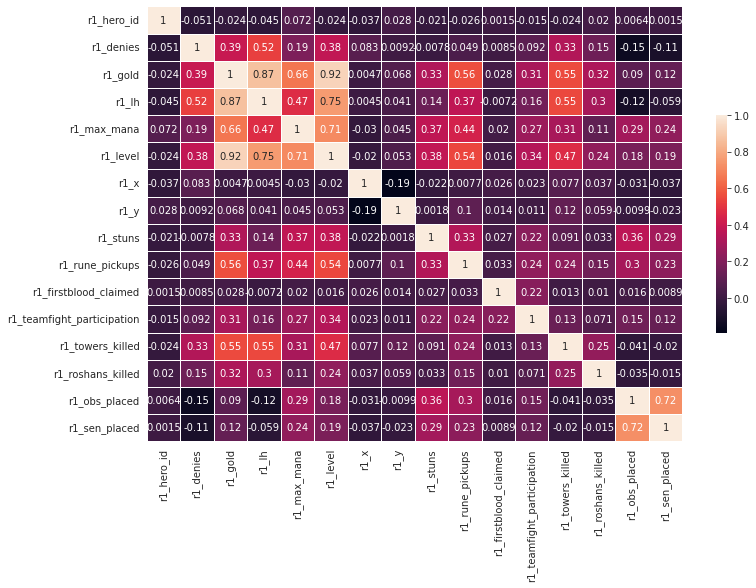

In [150]:
sns.heatmap(train.iloc[:,5:21].corr(), 
            annot=True, 
            linewidths=0.5, 
            cbar_kws={"shrink": 0.5})

In [151]:
# Observer + Sentry

for i in range(1, 6):
    train[f'r{i}_sum_senobs'] = train[f'r{i}_sen_placed'] + train[f'r{i}_obs_placed']
    train[f'd{i}_sum_senobs'] = train[f'd{i}_sen_placed'] + train[f'd{i}_obs_placed']
    
    train = train.drop([f'r{i}_sen_placed', f'r{i}_obs_placed', 
                        f'd{i}_sen_placed', f'd{i}_obs_placed'], axis=1)

<AxesSubplot:>

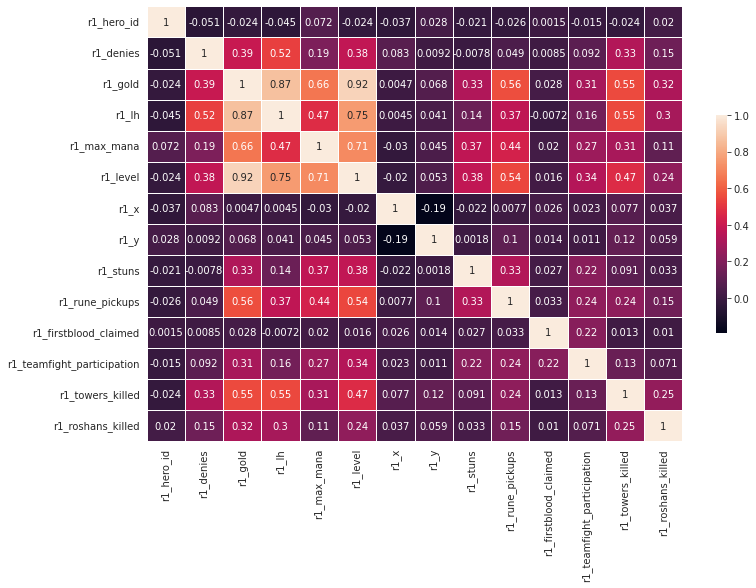

In [152]:
sns.heatmap(train.iloc[:,5:19].corr(), 
            annot=True, 
            linewidths=0.5, 
            cbar_kws={"shrink": 0.5})

In [153]:
# уровень с золотом очень коррелирует?
#уберем золото

#for i in range(1, 6):
    #train = train.drop([f'r{i}_gold', f'd{i}_gold'], axis=1)

<AxesSubplot:>

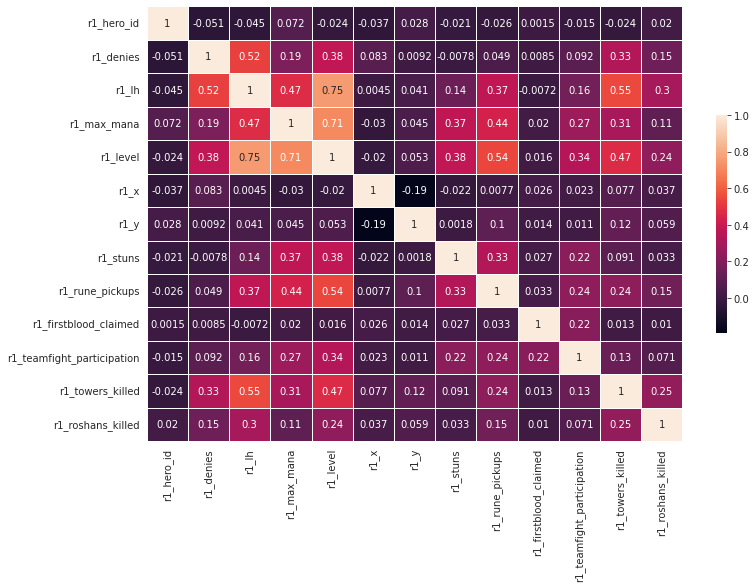

In [154]:
sns.heatmap(train.iloc[:,5:18].corr(), 
            annot=True, 
            linewidths=0.5, 
            cbar_kws={"shrink": 0.5})

In [155]:
train = train.reindex(sorted(train.columns), axis=1)

<AxesSubplot:>

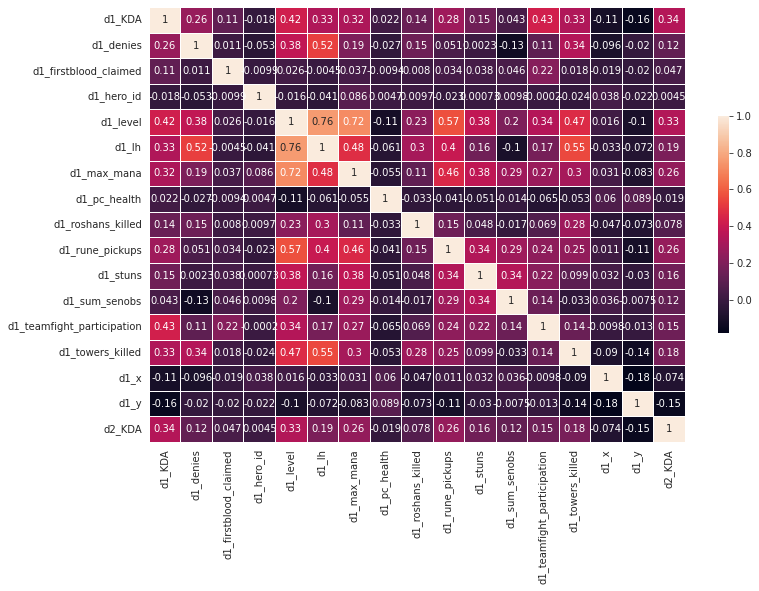

In [156]:
sns.heatmap(train.iloc[:,4:21].corr(), 
            annot=True, 
            linewidths=0.5, 
            cbar_kws={"shrink": 0.5})

по персонажам пока ок +-

проверим что у нас еще можно собрать в одно

In [157]:
train['r_roshans_killed'] = 0
train['d_roshans_killeds'] = 0
train['r_tower_kills'] = 0
train['d_tower_kills'] = 0

for i in range(1, 6):
    train['r_roshans_killed'] += train[f'r{i}_roshans_killed']
    train['d_roshans_killeds'] += train[f'd{i}_roshans_killed']
    
    train['r_tower_kills'] += train[f'r{i}_towers_killed']
    train['d_tower_kills'] += train[f'd{i}_towers_killed']
    
    train = train.drop([f'r{i}_towers_killed', f'd{i}_towers_killed'], axis=1)
    train = train.drop([f'r{i}_roshans_killed', f'd{i}_roshans_killed'], axis=1)

In [158]:
train = train.reindex(sorted(train.columns), axis=1)

In [162]:
train['d_camps_sen_sum'] = train['d_camps_sum'] + train['d_crepps_sum']
train['r_camps_sen_sum'] = train['r_camps_sum'] + train['r_crepps_sum']

In [163]:
train = train.drop(['objectives_len', 'diff_tower_kills', 'diff_roshan_kills',
                    'd_camps_sum', 'd_crepps_sum', 'r_camps_sum', 'r_crepps_sum'], axis=1)

In [167]:
slice_ = ['aegis_denied_diff', 'aegis_stolen_diff', 'barracks_kill', 'chat_len',
          'd_camps_sen_sum', 'r_camps_sen_sum', 'd_roshans_killeds', 'd_tower_kills', 
          'dire_ability_uses', 'first_blood', 
          'game_mode', 'game_time', 'lobby_type',
          'r_roshans_killed', 'r_tower_kills', 'rad_ability_uses']

<AxesSubplot:>

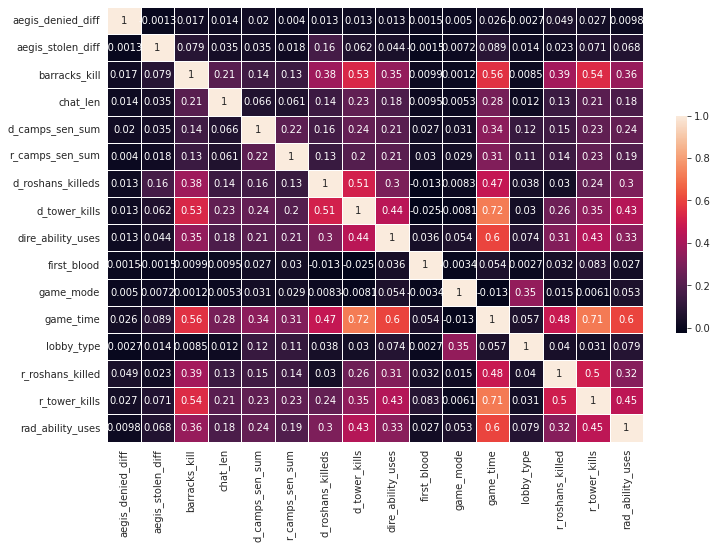

In [168]:
sns.heatmap(train[slice_].corr(), 
            annot=True, 
            linewidths=0.5, 
            cbar_kws={"shrink": 0.5})

<AxesSubplot:>

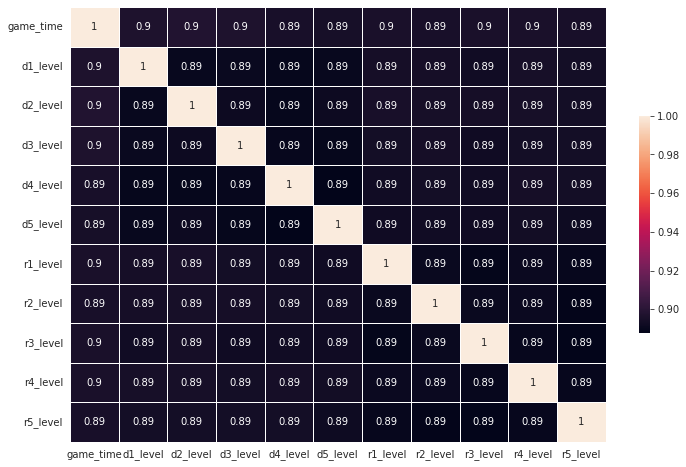

In [171]:
sns.heatmap(train[['game_time', 
                   'd1_level', 'd2_level', 'd3_level', 'd4_level', 'd5_level',
                   'r1_level', 'r2_level', 'r3_level', 'r4_level', 'r5_level',
                  ]].corr(), 
            annot=True, 
            linewidths=0.5, 
            cbar_kws={"shrink": 0.5})

Если собрать всё в "средний уровень команды"?

In [172]:
train['r_level'] = 0
train['d_level'] = 0

for i in range(1, 6):
    train['r_level'] += train[f'r{i}_level']
    train['d_level'] += train[f'd{i}_level']

<AxesSubplot:>

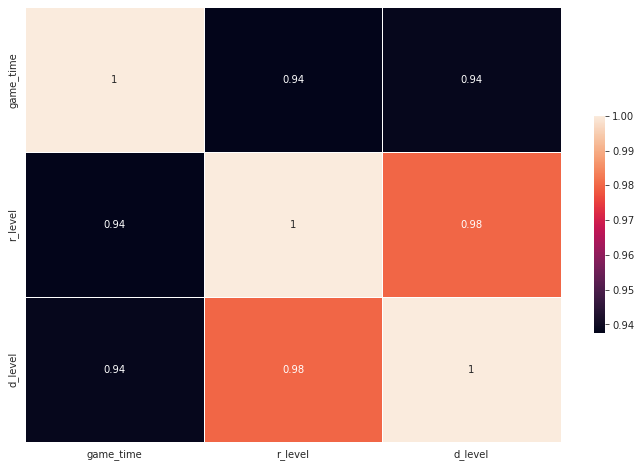

In [173]:
sns.heatmap(train[['game_time', 'r_level', 'd_level'
                  ]].corr(), 
            annot=True, 
            linewidths=0.5, 
            cbar_kws={"shrink": 0.5})

всё бессмысленно, можно оставить только время игры

In [174]:
#train['dr_level'] = train['r_level'] / train['d_level']

train = train.drop([#'r_level', 'd_level',
                    'd1_level', 'd2_level', 'd3_level', 'd4_level', 'd5_level',
                    'r1_level', 'r2_level', 'r3_level', 'r4_level', 'r5_level',
                   ], axis=1)

In [194]:
for i in range(1,6):
    train = train.drop([f'd{i}_x', f'd{i}_y', f'r{i}_x', f'd{i}_y'], axis=1)

<AxesSubplot:>

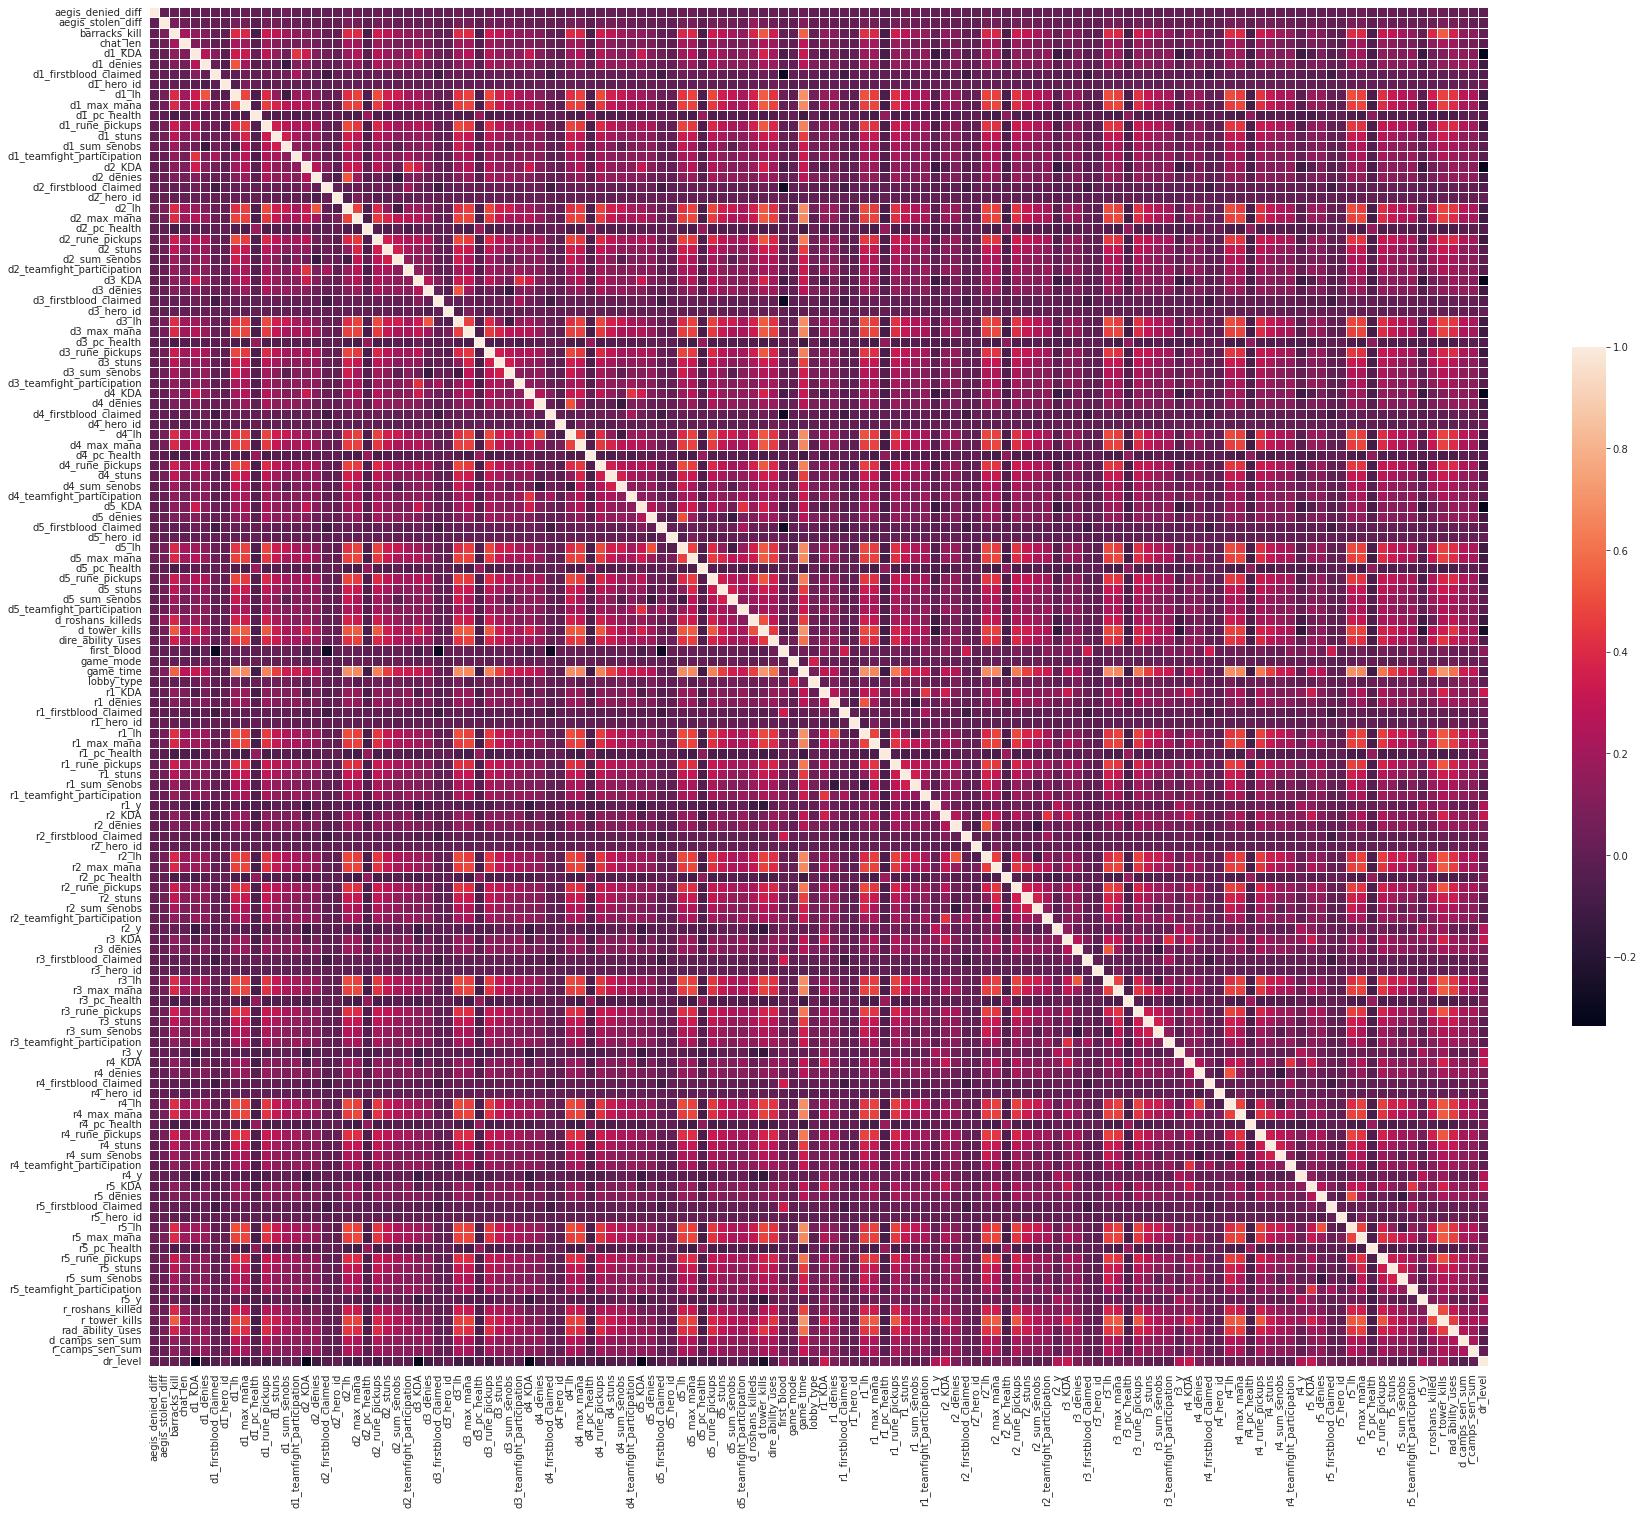

In [195]:
plt.figure(figsize=(30, 25))
sns.heatmap(train.corr(),
            linewidths=0.5, 
            cbar_kws={"shrink": 0.5})

+- ок

# Подготовим данные теста

In [198]:
df_test_features = pd.read_csv(os.path.join('../data', "test_data.csv"), 
                                            index_col="match_id_hash")

test = df_test_features.copy()

In [199]:
# Скопируем таблицу с признаками

# Добавим новые
add_new_features(test, 
                 os.path.join('../data', 
                              "test_raw_data.jsonl"),
                total_matches = 7977)

  0%|          | 0/7977 [00:00<?, ?it/s]

In [200]:
test['r_roshans_killed'] = 0
test['d_roshans_killeds'] = 0
test['r_tower_kills'] = 0
test['d_tower_kills'] = 0
test['r_level'] = 0
test['d_level'] = 0
test['r_crepps_sum'] = 0
test['d_crepps_sum'] = 0
test['r_camps_sum'] = 0
test['d_camps_sum'] = 0


for i in range(1, 6):
    test = test.drop([f'd{i}_x', f'd{i}_y', f'r{i}_x', f'd{i}_y'], axis=1)
    
    test[f'd{i}_KDA'] = np.where(test[f'd{i}_deaths'] != 0, 
                                 (test[f'd{i}_kills'] + test[f'd{i}_assists']) / test[f'd{i}_deaths'],
                                  test[f'd{i}_kills'] + test[f'd{i}_assists'])
        
    test[f'r{i}_KDA'] = np.where(test[f'r{i}_deaths'] != 0, 
                                 (test[f'r{i}_kills'] + test[f'r{i}_assists']) / test[f'r{i}_deaths'],
                                  test[f'r{i}_kills'] + test[f'r{i}_assists'])
    
    test[f'r{i}_pc_health'] = test[f'r{i}_health'] / test[f'r{i}_max_health']
    test[f'd{i}_pc_health'] = test[f'd{i}_health'] / test[f'd{i}_max_health']
    
    test[f'r_crepps_sum'] += test[f'r{i}_creeps_stacked']
    test[f'd_crepps_sum'] += test[f'd{i}_creeps_stacked'] 
    
    test[f'r_camps_sum'] += test[f'r{i}_camps_stacked']
    test[f'd_camps_sum'] += test[f'd{i}_camps_stacked']

    test[f'r{i}_sum_senobs'] = test[f'r{i}_sen_placed'] + test[f'r{i}_obs_placed']
    test[f'd{i}_sum_senobs'] = test[f'd{i}_sen_placed'] + test[f'd{i}_obs_placed']
    
    test['r_roshans_killed'] += test[f'r{i}_roshans_killed']
    test['d_roshans_killeds'] += test[f'd{i}_roshans_killed']
    
    test['r_tower_kills'] += test[f'r{i}_towers_killed']
    test['d_tower_kills'] += test[f'd{i}_towers_killed']
    
    test['r_level'] += test[f'r{i}_level']
    test['d_level'] += test[f'd{i}_level']
    
    test = test.drop([f'r{i}_health', f'r{i}_max_health', 
                        f'd{i}_health', f'd{i}_max_health',
                        f'd{i}_xp', f'r{i}_xp',
                        f'd{i}_kills', f'd{i}_assists', f'd{i}_deaths',
                        f'r{i}_kills', f'r{i}_assists', f'r{i}_deaths',
                        f'r{i}_creeps_stacked', f'r{i}_camps_stacked', 
                        f'd{i}_creeps_stacked', f'd{i}_camps_stacked',
                        f'r{i}_sen_placed', f'r{i}_obs_placed', 
                        f'd{i}_sen_placed', f'd{i}_obs_placed',
                        #f'r{i}_gold', f'd{i}_gold',
                        f'r{i}_towers_killed', f'd{i}_towers_killed',
                        f'r{i}_roshans_killed', f'd{i}_roshans_killed'], 
                       axis=1)

    
#test['dr_level'] = test['r_level'] / test['d_level']
test['d_camps_sen_sum'] = test['d_camps_sum'] + test['d_crepps_sum']
test['r_camps_sen_sum'] = test['r_camps_sum'] + test['r_crepps_sum']

test = test.drop(['objectives_len', 'diff_tower_kills', 'diff_roshan_kills',
                  'd_camps_sum', 'd_crepps_sum', 'r_camps_sum', 'r_crepps_sum'], axis=1)

test = test.drop([#'r_level', 'd_level',
                    'd1_level', 'd2_level', 'd3_level', 'd4_level', 'd5_level',
                    'r1_level', 'r2_level', 'r3_level', 'r4_level', 'r5_level',
                   ], axis=1)

In [221]:
train

,aegis_denied_diff,aegis_stolen_diff,barracks_kill,chat_len,d1_KDA,d1_denies,d1_firstblood_claimed,d1_hero_id,d1_lh,d1_max_mana,...,r5_stuns,r5_sum_senobs,r5_teamfight_participation,r5_y,r_roshans_killed,r_tower_kills,rad_ability_uses,d_camps_sen_sum,r_camps_sen_sum,dr_level
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,0.0,0.0,0.0,10,0.500000,4,0,58,24,686.93820,...,21.697395,0,0.375000,148,0,1,94.0,5,3,1.233333
6db558535151ea18ca70a6892197db41,0.0,0.0,0.0,0,0.000000,0,0,18,0,266.93774,...,0.000000,0,0.000000,142,0,0,1.0,0,0,1.000000
19c39fe2af2b547e48708ca005c6ae74,0.0,0.0,0.0,0,0.000000,0,0,48,1,278.93777,...,4.132324,1,0.000000,164,0,0,10.0,0,0,1.090909
c96d629dc0c39f0c616d1949938a6ba6,0.0,0.0,0.0,0,1.000000,18,0,47,46,506.93800,...,9.730849,0,0.400000,138,0,0,186.0,0,0,0.979592
156c88bff4e9c4668b0f53df3d870f1b,0.0,0.0,0.0,2,6.000000,3,0,51,1,326.93780,...,0.000000,2,0.000000,78,0,0,140.0,8,19,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,0.0,0.0,4.0,8,1.437500,0,0,14,18,1004.93850,...,76.575090,0,0.548387,78,0,2,1143.0,6,0,0.946429
308faee28efee2e66b39f9f2ba6ea9cf,0.0,0.0,0.0,5,2.333333,1,1,105,119,1639.93910,...,0.000000,32,0.370370,138,1,1,453.0,8,5,1.125000
6066cc7417b43c749d551e123d00f0c8,0.0,0.0,0.0,0,8.000000,8,0,41,73,458.93793,...,24.227467,0,0.714286,148,0,1,146.0,0,0,0.897959


# Тест получившегося

In [196]:
%%time

X = train.values
y = df_train_targets["radiant_win"].values.astype("int8")

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.795023520137309
CPU times: user 9.88 s, sys: 956 ms, total: 10.8 s
Wall time: 33.6 s


In [185]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

In [186]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

ROC-AUC score на отложенной части: 0.7967217437767496
Accuracy score (p > 0.5) на отложенной части: 0.7101997896950578


# Другой способ

In [219]:
#max_features
# Number of trees in random forest
n_estimators = list(range(50, 400, 50)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = list(range(1, 50, 2))
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6]

# Create the random grid
parameters = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': [True],
              'n_jobs': [-1],
               }

clf = RandomForestClassifier()
grid = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')

# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

KeyboardInterrupt: 

# Подготовим посылку

In [209]:
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(train, y)

y_test_pred = rf_model.predict_proba(test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-26_16-19-49.csv


чет плохо

In [203]:
y_test_pred = rf_model.predict_proba(test)

In [207]:
y_test_pred

array([[0.72639987, 0.27360013],
       [0.73650779, 0.26349221],
       [0.71327924, 0.28672076],
       ...,
       [0.69772574, 0.30227426],
       [0.68530352, 0.31469648],
       [0.57145685, 0.42854315]])

# GS